In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
plt.style.use('dark_background')

# 사진 촬영 & 로드하기

In [2]:
capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while True:
    ret, frame = capture.read()
    cv2.imshow("VideoFrame", frame)
    if cv2.waitKey(1) > 0: break

capture.release()
cv2.destroyAllWindows()
CAM_ID = 0
def capture(camid = CAM_ID):
    cam = cv2.VideoCapture(camid)
    if cam.isOpened() == False:
        print ('cant open the cam (%d)' % camid)
        return None

    ret, frame = cam.read()
    if frame is None:
        print ('frame is not exist')
        return None
    
    # png로 압축 없이 영상 저장 
    cv2.imwrite('1.jpg',frame, params=[cv2.IMWRITE_PNG_COMPRESSION,0])
    cam.release()
    
if __name__ == '__main__':
    capture()

img_ori = cv2.imread('1.jpg') #인식할 사진을 로드한다

height, width, channel = img_ori.shape # 이미지 너비, 높이, 채널을 저장한다

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

KeyboardInterrupt: 

# 사진을 회색으로 바꾸기

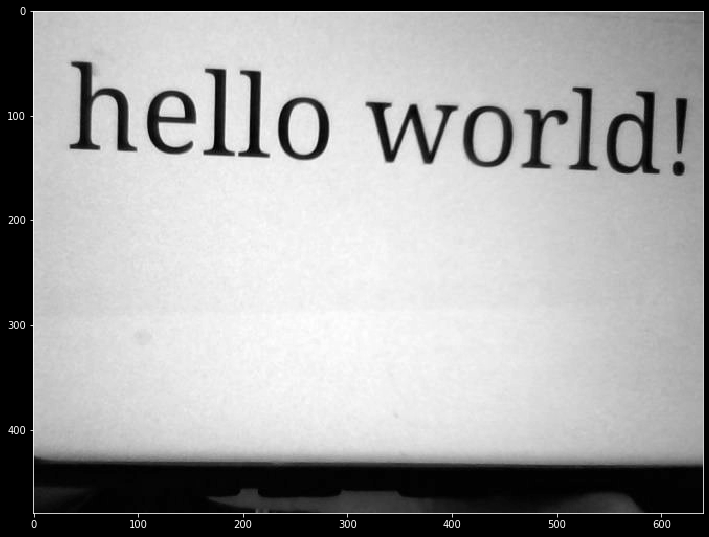

In [22]:
# hsv = cv2.cvtColor(img_ori, cv2.COLOR_BGR2HSV)
# gray = hsv[:,:,2]
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
#이미지 프로세싱을 하기쉽게할려고 BGR을 GRAY로 색을 변경한다.

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# 노이즈 제거 & 검정색 또는 흰색으로 분류

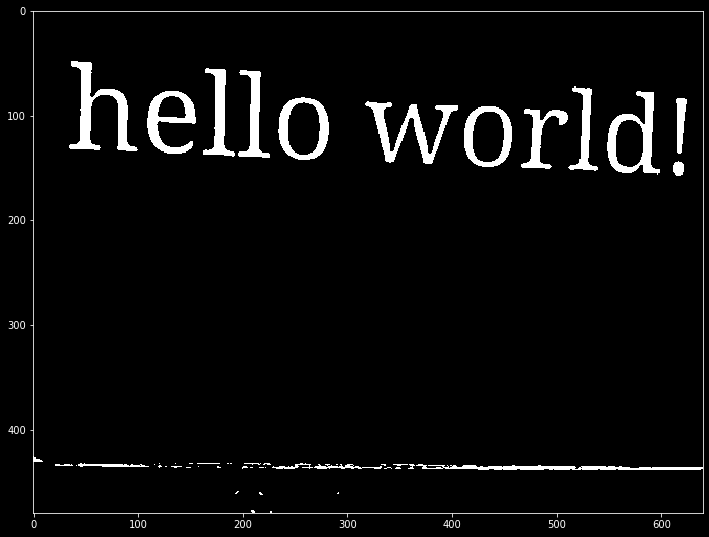

In [23]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
# cv2.GaussianBlur()는 이미지의 노이즈를 없에준다
img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)
# cv2.adaptiveThreshold() 이지지를 구분하기 쉽게하려고 특정 값을 기준으로 아래면 0, 위면 255로 설정
# 이미지를 까만색과 흰색으로 나눠버림
plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

# 컨투어 찾기 & 윤곽선 찾기

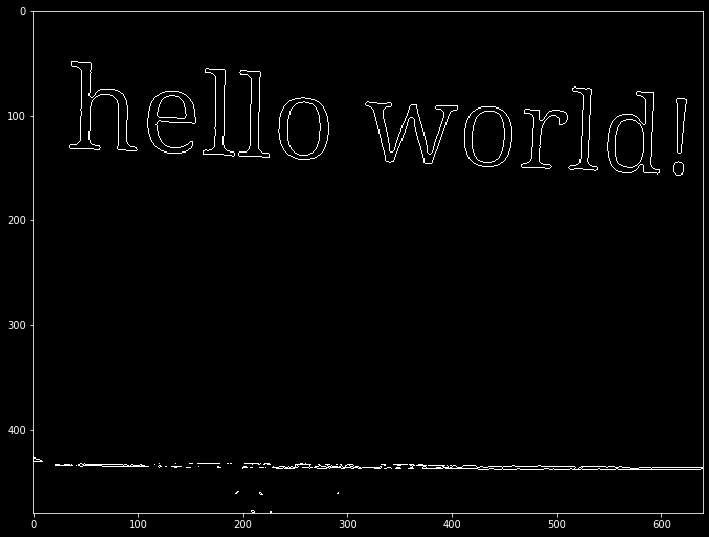

In [24]:
 contours, _ = cv2.findContours(img_thresh, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
# cv2.findContours() 윤곽선 찾기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))
#cv2.drawContours 컨투어를 그린다. / contourIdx=-1 전체 컨투어를 그린다
plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# 컨투어 영역을 사각형으로 표시

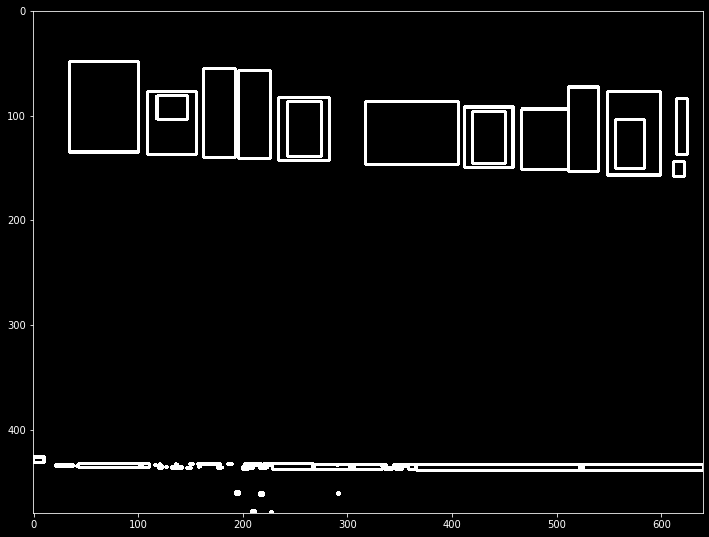

In [25]:

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
# cv2.boundingRect() 컨투어의 가각형 범위를 구한다.
# cv2.rectangle() 구한 사각형을 그린다.
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    }) # 컨투어에 x,y,w,h,중심좌표 x,y를 저장한다.

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')




# 컨투어 분류 1

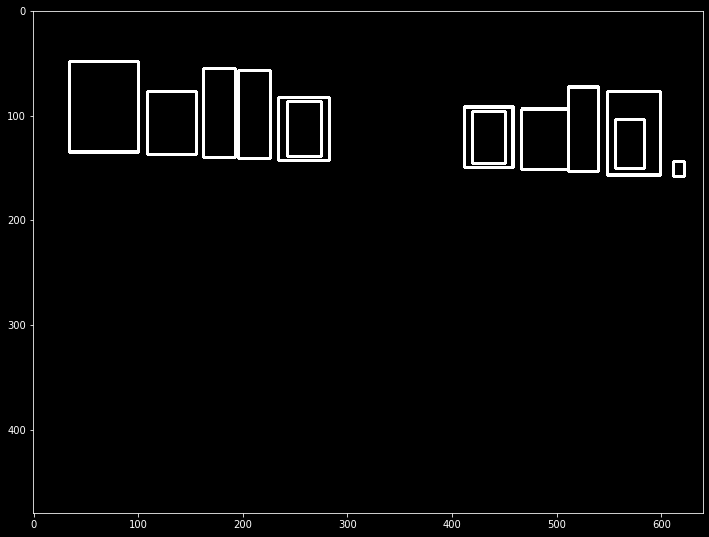

In [26]:
MIN_AREA = 80 # boundingRectdml 최소 넓이가 80이다.
MIN_WIDTH, MIN_HEIGHT = 2, 8 #boundingRect의 최소 넓이, 높이는 2,8이다.
MIN_RATIO, MAX_RATIO = 0.25, 1.0 #boundingRect 가로 대비 세로 비율은 0.25와 1.0이다

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h'] # 넓이
    ratio = d['w'] / d['h'] # 가로 대비 세로 비율
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d) #조건을 모두 만족할시 possible_contours에 저장
        # 인덱스의 값또한 같이 저장한다.
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours: #글자처럼 보이는것만 남아있다
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# 컨투어 분류 2

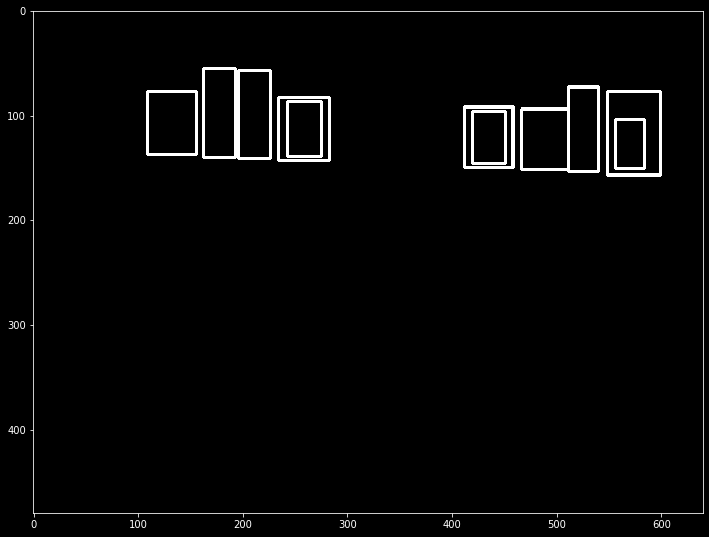

In [27]:
MAX_DIAG_MULTIPLYER = 5 # 5 / 첫번째 컨투어 사각형 대각선 중점과 두번째 사각형 중점길이가 5배로 가정
MAX_ANGLE_DIFF = 12.0 # 12.0 / 첫번째 컨투어와 두번째 컨투어랑 중심을 이으면 직각삼각형이 나오는데 각이 12정도로 가정
MAX_AREA_DIFF = 0.5 # 0.5 / 첫번째 사각형과 두번째 사각형 면적이 너무 0.5정도 이내로 차이가난다고 가정
MAX_WIDTH_DIFF = 0.8 # 0.8 / 첫번째 사각형과 두번째 사각형의 너비차이가 0.8이상 날경우 제외
MAX_HEIGHT_DIFF = 0.2 # 0.2 / 첫번째 사각형과 두번째 사각형의 높이차이가 0.2이상 날경우 제외
MIN_N_MATCHED = 3 # 3 / 위조건을 모두 만족한 그룹안에 사각형이 3개 미만일떄 그 그룹을 제외
# 위는 6개의 파라미터를 지정해준 값이다,
def find_chars(contour_list): #Recursive(재귀적) 방식으로 문자 후보를 찾기
    matched_result_idx = [] # 남는 결과물의 인덱스값들을 저장
    
    for d1 in contour_list: # 첫번째 컨투어
        matched_contours_idx = []
        for d2 in contour_list: # 두번쨰 컨투어
            if d1['idx'] == d2['idx']: # 첫번째랑 두번째 컨투어가 같으면 비교할 필요가없기때문에
                continue # continue를 사용한다
            # 다음 2줄은 첫번째 컨투어와 두번째 컨투어 각각 중점을 이용하는내용이다
            # 각각 중점을 직각 삼각형으로 그렸을때( 직각이 아래)
            dx = abs(d1['cx'] - d2['cx']) # 밑변에 해당
            dy = abs(d1['cy'] - d2['cy']) # 높이에 해당

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            # diagonal_length1는 d1의 대각선 길이

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            # np.linalg.norm 백터 a와 백터 b사이의 거리를 구한다
            # 이를 이용해서 d1,d2중점의 거리를 구한다
            
            if dx == 0: # d1과 d2가 x가 0이고 y만 차이가 날떄 오류를 막기위해 사용
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # np.arctan() 아크탄젠트값을 구한다 ( 라디안 ))
                # 구하면 라디안 값이 나오는데 라이단은 np.degrees()을 이용해서 도(각도)로 변경한다
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            # area_diff = 면적의 비율
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            # width_diff = 너비의 비율
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            # height_diff = 높이의 비율

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                # 아까 설정한 파라미터 값 비교
                matched_contours_idx.append(d2['idx']) # 모두일치하다면 인덱스만 리스트에 넣는다
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED: # 그룹에 인덱스 갯수와 파라미터값 비교
            continue

        matched_result_idx.append(matched_contours_idx) #최종 후보군을 저장

        unmatched_contour_idx = [] # 후보가 아닌것들을 비교
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx: #matched_contours_idx가 아닌것들
                unmatched_contour_idx.append(d4['idx'])# unmatched_contour_idx.append에 저장

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        # np.take() a에서 idx와 같은 인덱스의 값만 추출
        
        recursive_contour_list = find_chars(unmatched_contour)
        # 아까만든 find_char함수에 재귀함수로 돌린다 / 나온 리스트를 저장
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx) # 나온값으 최종 후보에 다시 넣어준다
#find_char 함수 끝
        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result: #나온값을들 사각형으로 그린다
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# 남은 컨투어를 이용해 이미지 편집

443.3 74 414.5 120.25
522.6 88 310.5 115.0
568.1 123 375.5 107.25


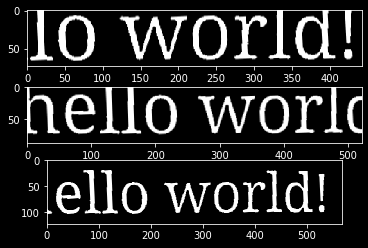

In [28]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result): #반복문을 사용하면서
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    # X방향으로 순차적으로 한번 정렬을 해준다

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    #가장 끝과 끝 사각형 중점을 기준으로 작동한다
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm( #hypotenus 빗변의 길이
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    #아까 설명한것처럼 각도를 구하는 내용
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    # cv2.getRotationMatrix2D() 로테이션 매트릭스를 구한다
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    # cv2.warpAffine() 이미지를 변형한다
    # 위 2줄로 삐뚤어진 이미지를 회전시켜 똑바로 돌린다
    img_cropped = cv2.getRectSubPix( #cv2.getRectSubPix() 회전된 이미지에서 원하는 부분만 잘라낸다
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    ) #글자영역만 잘라낸다
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    print(plate_width ,plate_height ,plate_cx ,plate_cy)
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# 마지막 분류 & 글자 확인


result_chars: 
has_digit: False
len(result_chars): 0
longest_text: 0
i :  0

result_chars: 
has_digit: False
len(result_chars): 0
longest_text: 0
i :  1

result_chars: 
has_digit: False
len(result_chars): 0
longest_text: 0
i :  2


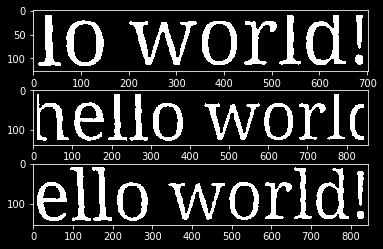

In [29]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # cv2.threshold() 쓰레시홀딩
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    # 글자영역의 최종 좌표
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    # cv2.GaussianBlur() 노이즈 제거
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # cv2.threshold() 쓰레시홀딩
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    # cv2.copyMakeBorder() 이미지안에 약간의 여백을 추가한다
    # 여백 색은 value=(0,0,0)로 변경가능
    
    chars = pytesseract.image_to_string(img_result, lang='eng')
    # pytesseract.image_to_string() 이미지에서 글자를 읽는다
    # config='psm 7' 이미지안에 글자가 한줄로 놓여있다는 조건을 줌
    # config='oem 0' 여러가지 엔진중 가장 옛날 엔진을 사용 / 문맥이해를 제거
    # 오류로 제가
    result_chars = ''
    has_digit = False
    #특수문자 제거
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    cv2.imwrite('result.jpg', img_result)
    print("result_chars:",result_chars)
    print("has_digit:",has_digit)
    print("len(result_chars):",len(result_chars))
    print("longest_text:",longest_text)
    print("i : ",i)

# 글자 영역 표시 & 글자 추출

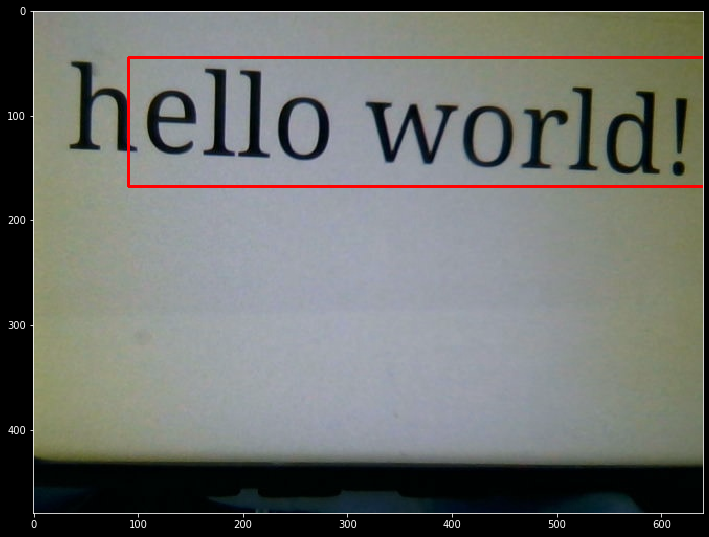

In [30]:

info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)
plt.figure(figsize=(12, 10))
plt.imshow(img_out)

img = Image.open("1.jpg")
area = (info['x'], info['y'], info['x']+info['w'], info['y']+info['h'])
bimg = img.crop(area)


ello world!]
ello world!


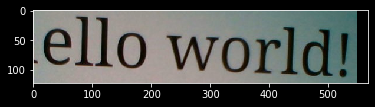

In [31]:
plt.imshow(bimg)
print(pytesseract.image_to_string(bimg, lang='eng'))
print(pytesseract.image_to_string('result.jpg', lang='eng'))